# Analysing and predicting stock prices

In [1]:
!pip install yfinance
!pip install yahoofinancials

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 491.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for yahoofinancials: filename=yahoofinancials-1.16-py3-none-any.whl size=28711 sha256=37207b59acb2aec68a3356205e575621a48d3e8fb7c5c0e2dbb7a4d302677c68
  Stored in directory: /root/.cache/pip/wheels/fd/fe/c4/4b17989f30abf08d147a72cd1097ae0f6b1a1dd070f3abf726
Successfully built yahoofinancials


## Import libraryies for EDA

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

import yfinance as yf
from yahoofinancials import YahooFinancials

import warnings
warnings.filterwarnings('ignore')

# for preprocess
from sklearn.preprocessing import StandardScaler

Whrite function to collect our data from Yahoo

In [4]:
def get_stock_price(company, period, print_plot=True):
    """
    input -  company: the name of the company on the exchange (also the name of the cryptocurrency)
                    Example: AAPL, GOOGL, TSLA, BTC;
             perid: what period of time should be taken from today's date. (If you enter too large a number, the maximum possible number of records is output )
                    Example: 1, 5, 10;
             print_plot: Whether it is necessary to plot price versus time.
                    Example: True if yes, False if not;

    output - dataset, collected from yahoo
    """

    stock_prices = yf.download(company)
    if period:
        ticker = yf.Ticker(company)
        stock_prices = ticker.history(period=f"{period}y")
        stock_prices['Date'] = stock_prices.index.date
        stock_prices.reset_index(drop=True, inplace=True)
    if print_plot:
        stock_prices['Close'].plot(title=f"{company}'s stock price")

    return stock_prices

Lets collect Google stock prices. You can choose company/crypto what you want

[*********************100%***********************]  1 of 1 completed


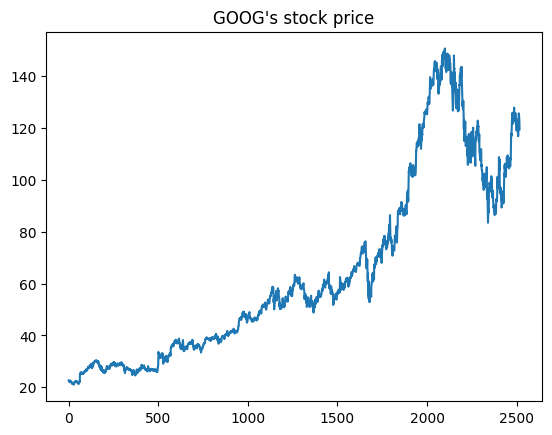

In [55]:
company_df = get_stock_price('GOOG', "10", True)

## Data analysis

In [9]:
company_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Date
0,22.465794,22.731546,22.341259,22.682480,116563276,0.0,0.0,2013-07-22
1,22.682480,22.739765,22.405270,22.510626,82134711,0.0,0.0,2013-07-23
2,22.596802,22.672518,22.433414,22.488209,83451629,0.0,0.0,2013-07-24
3,22.263302,22.337523,22.069279,22.109629,120493954,0.0,0.0,2013-07-25
4,22.091944,22.166664,21.967661,22.051098,71374530,0.0,0.0,2013-07-26


In [6]:
company_df.shape

(2517, 8)

In [8]:
company_df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,2517.000000,2517.000000,2517.000000,2517.000000,2.517000e+03,2517.0,2517.000000
mean,64.038391,64.719927,63.395261,64.071393,3.596321e+07,0.0,0.009140
std,35.579315,36.029020,35.173267,35.599591,2.209695e+07,0.0,0.401113
min,21.147484,21.305391,20.995804,21.093437,1.584340e+05,0.0,0.000000
25%,35.525002,35.914001,35.167999,35.544498,2.385600e+07,0.0,0.000000
50%,54.420502,55.099499,53.799999,54.452999,2.992400e+07,0.0,0.000000
75%,88.847000,89.779999,87.804497,88.850998,4.070144e+07,0.0,0.000000
max,151.863495,152.100006,149.887497,150.709000,4.643901e+08,0.0,20.000000


In [10]:
#see if we have any missing values
company_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2517 non-null   float64
 1   High          2517 non-null   float64
 2   Low           2517 non-null   float64
 3   Close         2517 non-null   float64
 4   Volume        2517 non-null   int64  
 5   Dividends     2517 non-null   float64
 6   Stock Splits  2517 non-null   float64
 7   Date          2517 non-null   object 
dtypes: float64(6), int64(1), object(1)
memory usage: 157.4+ KB


## Data visualisation

let's look at the graphs of the distribution of values in the following values

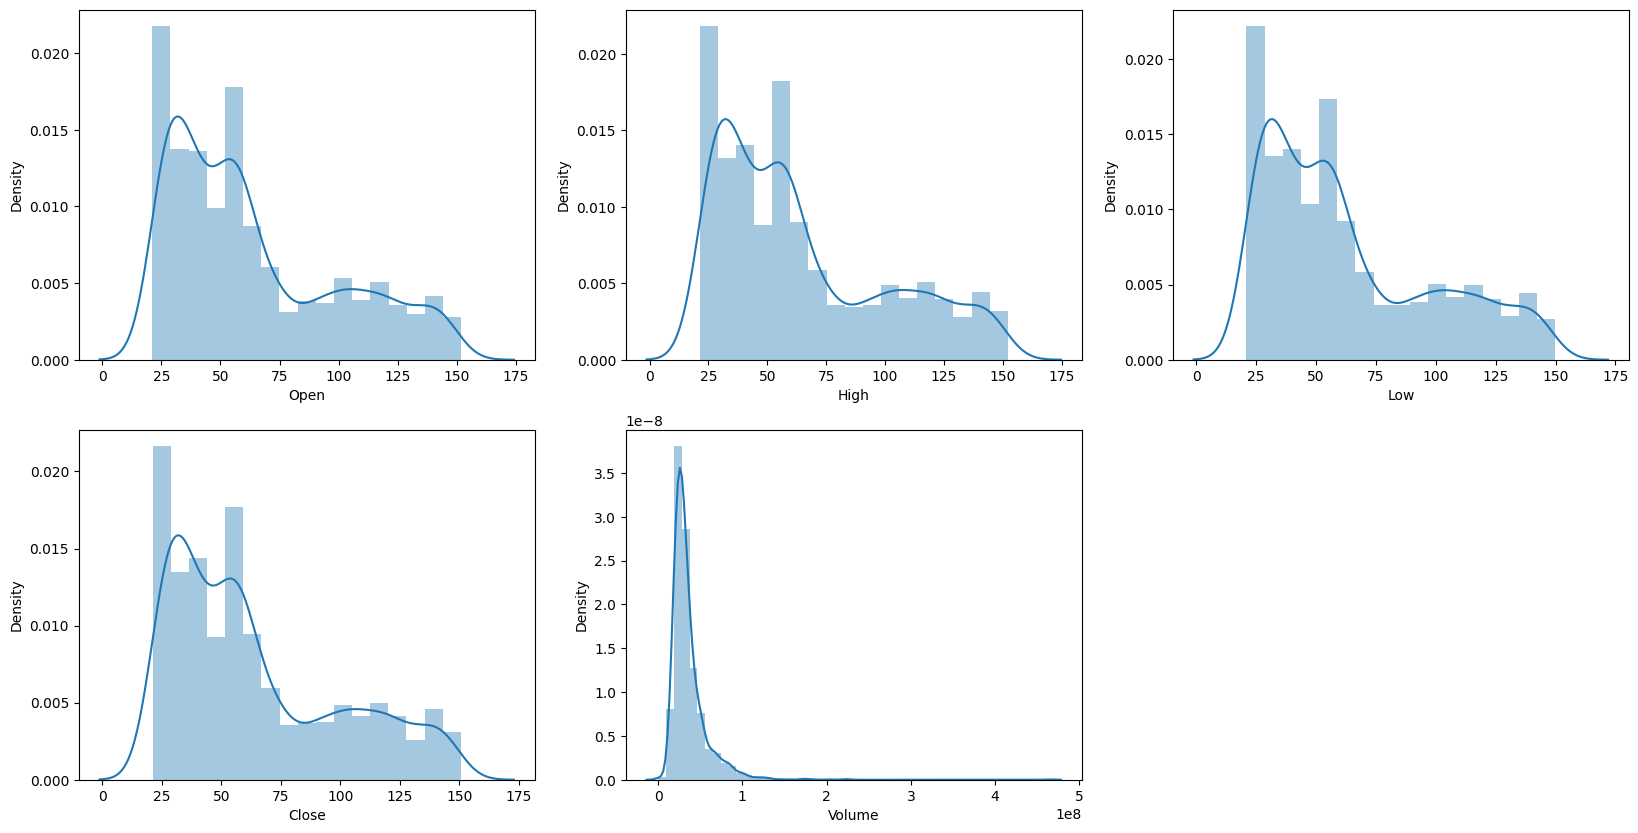

In [12]:
visualisation = ['Open', 'High', 'Low', 'Close', 'Volume']

plt.subplots(figsize=(20,10))

for i, col in enumerate(visualisation):
  plt.subplot(2,3,i+1)
  sb.distplot(company_df[col])
plt.show()

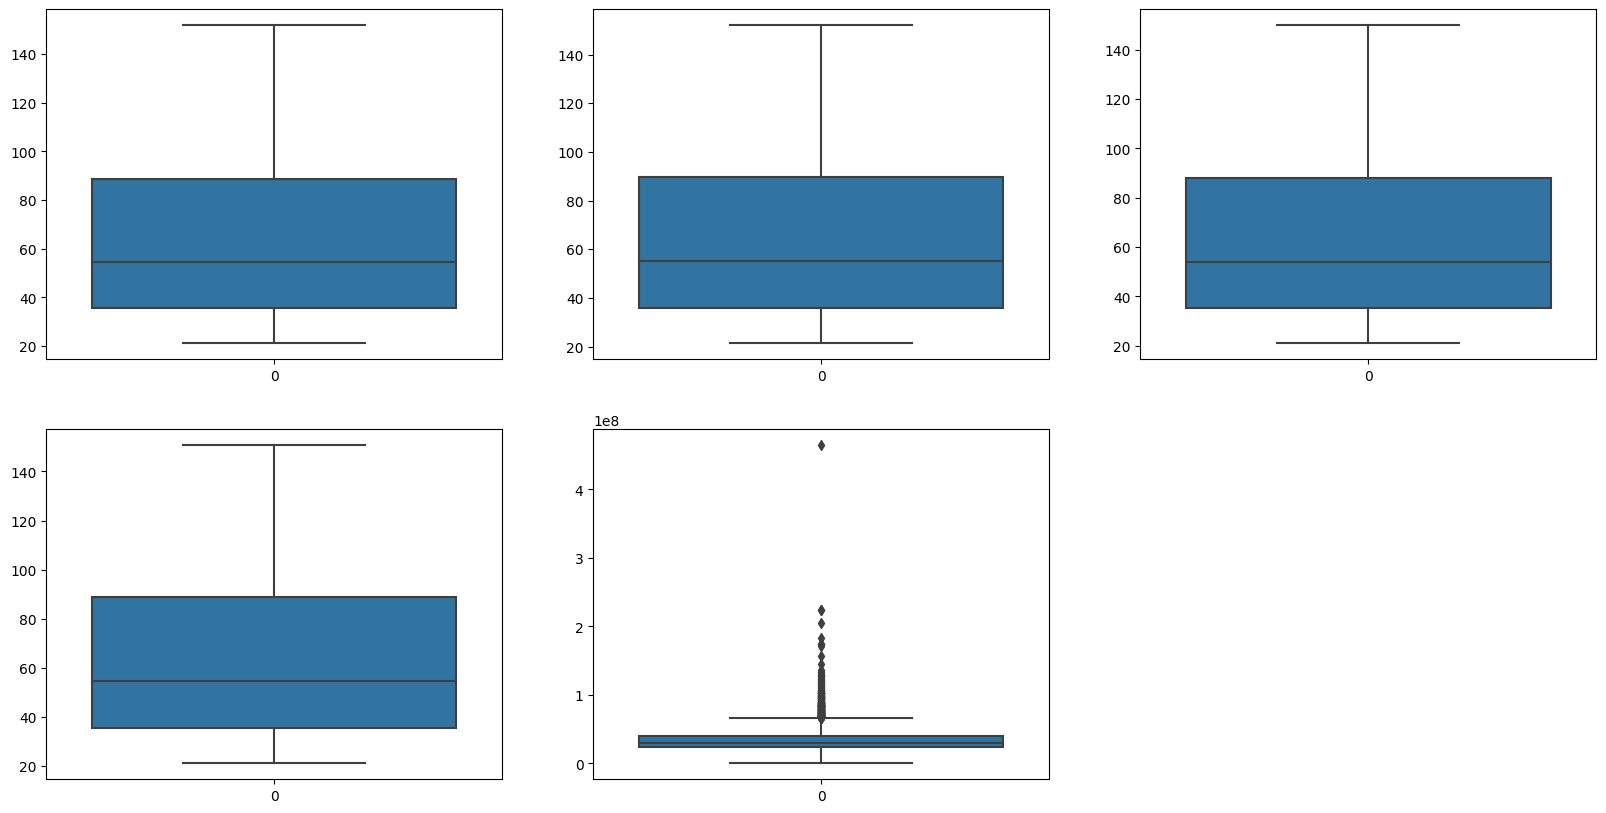

In [13]:
plt.subplots(figsize=(20,10))
for i, col in enumerate(visualisation):
  plt.subplot(2,3,i+1)
  sb.boxplot(company_df[col])
plt.show()

## Feature Engineering

let's get some of the new features out of the datе

In [53]:
def perform_data(df, scalar = False):
    """
    input -  df: dataset
             scalar : for quick data preparation before training the model

    output -  dataset, if scalar = False
              X, y - for further division into training and testing datasets, if scaler = True
    """

    try:
        df = df.drop(['Dividends','Stock Splits'], axis = 1)
    except:
        print('You need use "get_stock_price" func with "period"')

    df['day'] = df['Date'].apply(lambda i: i.day)
    df['month'] = df['Date'].apply(lambda i : i.month)
    df['year'] = df['Date'].apply(lambda i: i.year)
    df['is_quarter_end'] = np.where(df['month']%3==0,1,0)

    df['weekday'] = df['Date'].apply(lambda i: i.strftime('%A'))
    df['weekday_num'] = df['Date'].apply(lambda i: i.weekday() + 1)

    df['open-close']  = df['Open'] - df['Close']
    df['low-high']  = df['Low'] - df['High']

    # the 'target' column will have a value of 1 if the closing price
    # of the next trading day is higher than the current day's closing price,
    # and 0 if it is not. This way, the 'target' column is created to represent
    # the target variable for the binary classification task
    # based on the stock price movement.
    df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

    if scalar:
        to_scaler = ['Open','High', 'Low', 'Close', 'Volume' ]
        not_scaler = ['day', 'month','year','weekday_num','is_quarter_end', 'open-close',"low-high"]

        features_to_scale = df[to_scaler]

        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(features_to_scale)

        X = pd.DataFrame(scaled_features, columns=features_to_scale.columns)
        X[['day', 'month', 'year', 'weekday_num', 'is_quarter_end', 'open-close', 'low-high']] = df[not_scaler]
        y = df['target']

        return X, y

    return df

In [56]:
performed_df = perform_data(company_df, False)
performed_df

,Open,High,Low,Close,Volume,Date,day,month,year,is_quarter_end,weekday,weekday_num,open-close,low-high,target
0,22.465794,22.731546,22.341259,22.682480,116563276,2013-07-22,22,7,2013,0,Monday,1,-0.216686,-0.390287,0
1,22.682480,22.739765,22.405270,22.510626,82134711,2013-07-23,23,7,2013,0,Tuesday,2,0.171854,-0.334496,0
2,22.596802,22.672518,22.433414,22.488209,83451629,2013-07-24,24,7,2013,0,Wednesday,3,0.108593,-0.239103,0
3,22.263302,22.337523,22.069279,22.109629,120493954,2013-07-25,25,7,2013,0,Thursday,4,0.153673,-0.268244,0
4,22.091944,22.166664,21.967661,22.051098,71374530,2013-07-26,26,7,2013,0,Friday,5,0.040846,-0.199003,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,125.129997,127.089996,124.900002,125.699997,20482800,2023-07-14,14,7,2023,0,Friday,5,-0.570000,-2.189995,0
2513,126.059998,127.279999,124.500000,125.059998,20675300,2023-07-17,17,7,2023,0,Monday,1,1.000000,-2.779999,0
2514,124.904999,124.989998,123.300003,124.080002,21071200,2023-07-18,18,7,2023,0,Tuesday,2,0.824997,-1.689995,0
2515,124.790001,125.470001,122.470001,122.779999,22313800,2023-07-19,19,7,2023,0,Wednesday,3,2.010002,-3.000000,0


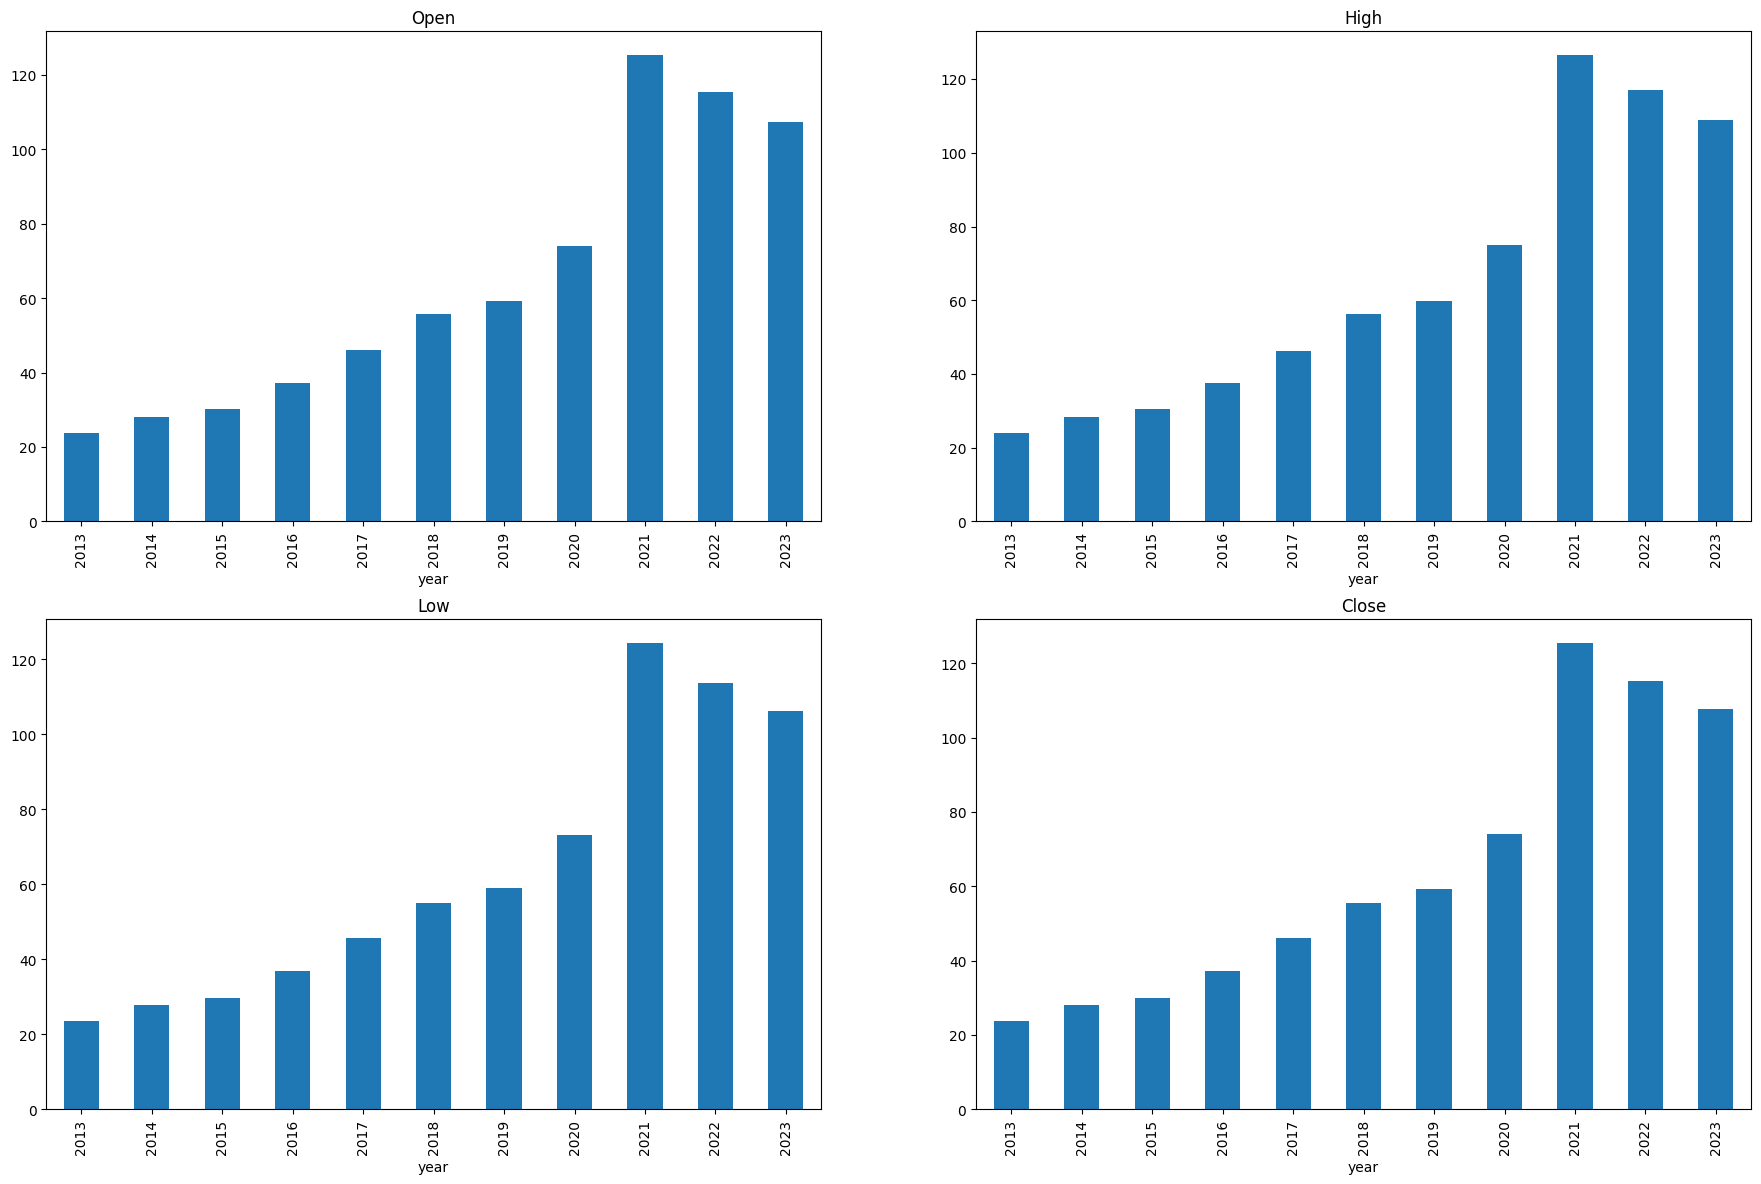

In [63]:
data_grouped = performed_df.groupby('year').mean()
plt.subplots(figsize=(22,14))

for i, col in enumerate(['Open', 'High', 'Low', 'Close']):
  plt.subplot(2,2,i+1)
  data_grouped[col].plot.bar()
  plt.title(col)
plt.show()

### According to the graph, we can say that the share price in the 21st year increased almost 2 times compared to the 22nd year.

some quarterly information

In [64]:
performed_df.groupby('is_quarter_end').mean()

,Open,High,Low,Close,Volume,day,month,year,weekday_num,open-close,low-high,target
is_quarter_end,,,,,,,,,,,,
0,63.811690,64.509191,63.185696,63.869163,3.633551e+07,15.733493,6.097239,2018.055822,3.020408,-0.057473,-1.323495,0.536615
1,64.482202,65.132485,63.805526,64.467298,3.523436e+07,15.772033,7.431257,2018.024677,3.024677,0.014904,-1.326959,0.502938


some information on the days of the week

In [65]:
performed_df.groupby('weekday').mean()

,Open,High,Low,Close,Volume,day,month,year,is_quarter_end,weekday_num,open-close,low-high,target
weekday,,,,,,,,,,,,,
Friday,64.058007,64.690404,63.398176,64.062770,4.018734e+07,15.829026,6.556660,2018.045726,0.335984,5.0,-0.004763,-1.292228,0.512922
Monday,63.523381,64.204531,62.902841,63.579682,3.530579e+07,15.730361,6.715499,2017.991507,0.337580,1.0,-0.056301,-1.301691,0.541401
Thursday,64.309493,65.025760,63.676248,64.380831,3.518055e+07,15.569745,6.442043,2018.078585,0.345776,4.0,-0.071338,-1.349512,0.491159
Tuesday,64.005999,64.650052,63.342955,63.989076,3.485898e+07,15.820463,6.530888,2018.040541,0.337838,2.0,0.016923,-1.307097,0.555985
Wednesday,64.254459,64.987618,63.617229,64.306025,3.432614e+07,15.781008,6.509690,2018.065891,0.333333,3.0,-0.051566,-1.370388,0.525194


- Trading volume Less at the end of quarters.
- Trading volume on Friday is also 13% higher than on Monday.

### Let's look at the distribution of our target
As a reminder, the 'target' column will have a value of 1 if the closing price of the next trading day is higher than the closing price of the current day, and 0 if it is not. Thus, the 'target' column is created to represent the target variable in the binary classification task based on the stock price movement.

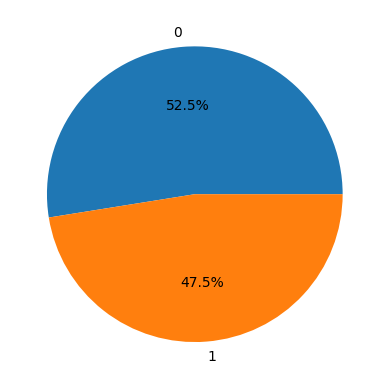

In [67]:
plt.pie(performed_df['target'].value_counts().values,
        labels=[0, 1], autopct='%1.1f%%')
plt.show()

## Since we added neutral features to our dataset, we need to make sure that they do not create a correlation with the rest of the features in our dataset

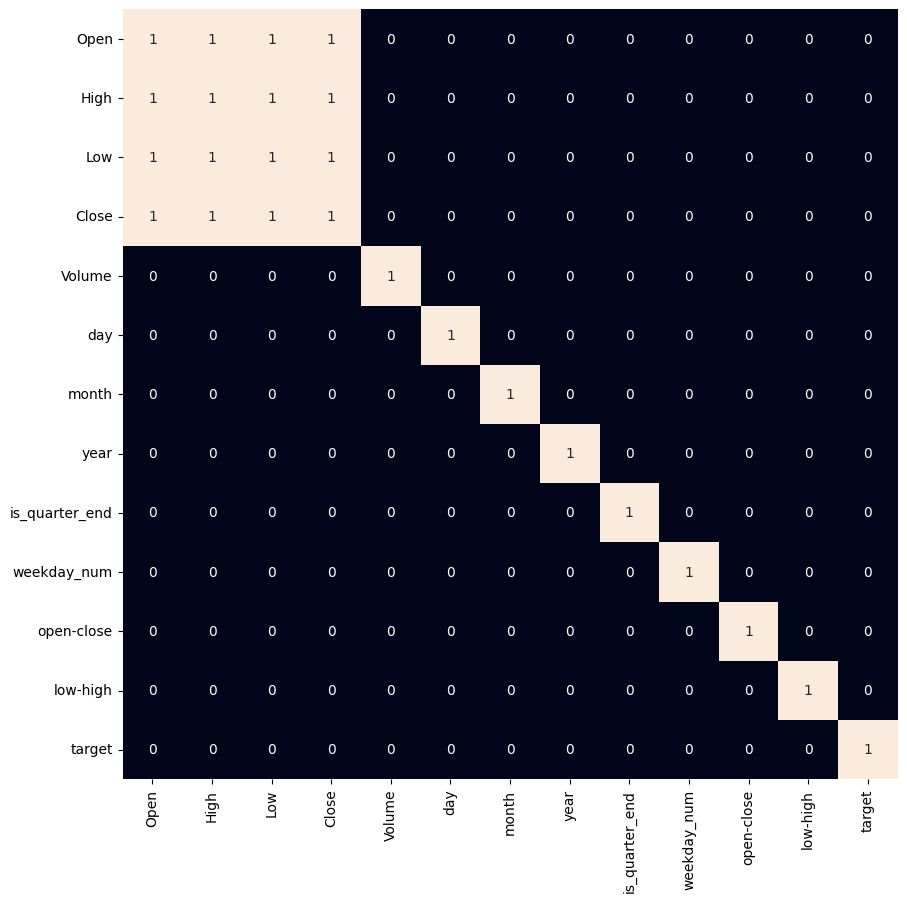

In [71]:
plt.figure(figsize=(10, 10))
sb.heatmap(performed_df.corr() > 0.9, annot=True, cbar=False)
plt.show()

## Model Training

In [77]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, average_precision_score, f1_score, precision_score, roc_auc_score

#the models that we'll be comparing
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

#for computing training time
import time

In [75]:
# scalar our dataset. all changes and preprocessing of the dataset
# can be seen in the function perform_data() after the line "if scalar:"
X, y = perform_data(company_df, True)
print(X.shape)
print(y.shape)

(2517, 12)
(2517,)


In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1706)
print(X_train.shape, X_test.shape)

(2013, 12) (504, 12)


In [79]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVC': SVC(),
    'Kneighbours default': KNeighborsClassifier(),
    'Gradient Boosting Classifier' : GradientBoostingClassifier(),
    'XGBoost Classifier' : XGBClassifier(),
    'ADA Boost' : AdaBoostClassifier(),
    'Naive Bayes' : GaussianNB(),
}

evaluation_df = pd.DataFrame({
    'Model': [],
    'Accuracy': [],
    'Average Precision': [],
    'F1': [],
    'roc-auc': [],
    'Training Time (s)': []
})

In [80]:
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()

    pred = model.predict(X_test)

    training_time = end_time - start_time
    print(f"{name} training is finished...")
    print("Confusion matrix is: ")
    print(pd.DataFrame(confusion_matrix(y_test, pred)))
    print(f"Spended time - {training_time}")
    print("~"*20)
    print("\n")

    accuracy = accuracy_score(y_test, pred)
    avg_precision = average_precision_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)
    training_time = end_time - start_time

    evaluation_df = evaluation_df.append({
        'Model': name,
        'Accuracy': accuracy,
        'Average Precision': avg_precision,
        'F1': f1,
        'roc-auc': roc_auc,
        'Training Time (s)': training_time
    }, ignore_index=True)

Logistic Regression training is finished...
Confusion matrix is: 
    0    1
0  71  169
1  73  191
Spended time - 0.31128931045532227
~~~~~~~~~~~~~~~~~~~~


Decision Tree training is finished...
Confusion matrix is: 
     0    1
0  127  113
1  128  136
Spended time - 0.2470381259918213
~~~~~~~~~~~~~~~~~~~~


Random Forest training is finished...
Confusion matrix is: 
     0    1
0  106  134
1  113  151
Spended time - 2.4349205493927
~~~~~~~~~~~~~~~~~~~~


SVC training is finished...
Confusion matrix is: 
   0    1
0  0  240
1  0  264
Spended time - 0.33078646659851074
~~~~~~~~~~~~~~~~~~~~


Kneighbours default training is finished...
Confusion matrix is: 
     0    1
0  117  123
1  110  154
Spended time - 0.006898641586303711
~~~~~~~~~~~~~~~~~~~~


Gradient Boosting Classifier training is finished...
Confusion matrix is: 
    0    1
0  85  155
1  87  177
Spended time - 1.136765480041504
~~~~~~~~~~~~~~~~~~~~


XGBoost Classifier training is finished...
Confusion matrix is: 
     0    1


In [81]:
evaluation_df

,Model,Accuracy,Average Precision,F1,roc-auc,Training Time (s)
0,Logistic Regression,0.519841,0.528690,0.612179,0.509659,0.311289
1,Decision Tree,0.521825,0.535336,0.530214,0.522159,0.247038
2,Random Forest,0.509921,0.527250,0.550091,0.506818,2.434921
3,SVC,0.523810,0.523810,0.687500,0.500000,0.330786
4,Kneighbours default,0.537698,0.542562,0.569316,0.535417,0.006899
5,Gradient Boosting Classifier,0.519841,0.530060,0.593960,0.512311,1.136765
6,XGBoost Classifier,0.523810,0.534776,0.558824,0.521212,1.595955
7,ADA Boost,0.529762,0.535629,0.597623,0.522917,0.209644
8,Naive Bayes,0.519841,0.528496,0.614650,0.509280,0.002324


##After looking at the results of the models, one can realise that the models are simply guessing whether the price will rise tomorrow or not. This once again confirms that predicting the price of a stock by machine learning is quite difficult. Such algorithms are used in trading bots, and they cost exorbitant amounts of money.

##It's the same with cryptocurrencies. The price itself is influenced not by the usual exchange indicators, but by many different factors, such as the words of regulators in different countries, the presence of wars/cataclysms or emergencies. It is also worth considering that there is such a story as "Pump" of a certain currency/bond, as it happened recently with GameStop